### Imports

In [73]:
import matplotlib.pyplot as plt
import lightning.pytorch as pl
import torch
import torch.nn as nn
import torch.nn.functional  as F
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

#### Data Load - MNIST

In [2]:
image, label = torch.load(r'C:\Users\vnaza\OneDrive\Documentos\Projetos\DeepLearning\MNIST - Pytorch\Data\MNIST\processed\training.pt')

In [3]:
print(f'X Shape = {image.shape} - its the tensor representation of a image')
print(f'y Shape = {label.shape} - its the representataton of the image label')
# print('\n')
# print(f'X sample = {x[0]}')
print(f'y sample = {label[0:5]}')

X Shape = torch.Size([60000, 28, 28]) - its the tensor representation of a image
y Shape = torch.Size([60000]) - its the representataton of the image label
y sample = tensor([5, 0, 4, 1, 9])


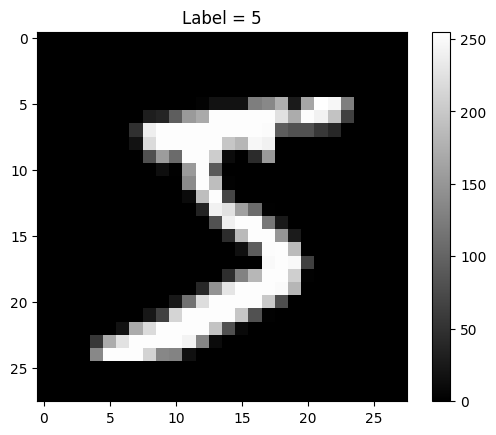

In [4]:
plt.imshow(image[0], cmap=plt.get_cmap('gray'))
plt.title(f'Label = {label[0]}')
plt.colorbar()

### Processing the data labels - One Hot Encoder

In [5]:
y_example = torch.tensor([0,1,2,3,4,5,6])
y_example_one_hot = F.one_hot(y_example)

In [6]:
print('Actual labels: \n', y_example)
print('One Hot Encoded labels: \n', y_example_one_hot)

Actual labels: 
 tensor([0, 1, 2, 3, 4, 5, 6])
One Hot Encoded labels: 
 tensor([[1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1]])


In [7]:
y_onehot = F.one_hot(y, num_classes=10)

In [8]:
y

tensor([5, 0, 4,  ..., 5, 6, 8])

In [9]:
y_onehot

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0]])

### Image Issues

In [10]:
x.view(-1, 28**2).shape

torch.Size([60000, 784])

### What is a Pytorch Dataset?

In [123]:
class MNISTImageDataset(Dataset):
    def __init__(self, filepath, num_classes, normalize=True):
        self.image, self.label = torch.load(filepath)
        if normalize:
            self.image = self.image/255
        self.label = F.one_hot(self.label, num_classes=num_classes).to(float)
        
    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.image[idx], self.label[idx]
    
    def show_image(self,idx):
        plt.imshow(self.image[idx], cmap=plt.get_cmap('gray'))
        plt.title(f'Target Label = {self.label[idx]}')
        plt.colorbar()

In [124]:
train_set = MNISTImageDataset(r'C:\Users\vnaza\OneDrive\Documentos\Projetos\DeepLearning\MNIST - Pytorch\Data\MNIST\processed\training.pt', num_classes=10)
test_set = MNISTImageDataset(r'C:\Users\vnaza\OneDrive\Documentos\Projetos\DeepLearning\MNIST - Pytorch\Data\MNIST\processed\test.pt', num_classes=10)


### What is a Pytorch Dataloader?

In [125]:
train_loader = DataLoader(train_set, batch_size=5)
test_loader = DataLoader(test_set, batch_size=5, shuffle=True)
# validation_loader = DataLoader(validation_set, batch_size=64, shuffle=True)

In [46]:
m = nn.Flatten()
for image, label in train_loader:
    print(m(image).shape)
    print(label.shape) 
    break

torch.Size([5, 784])
torch.Size([5])


### Network Model

In [126]:
class FeedForwardNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        
        self.network = torch.nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            # nn.Softmax(1)
        )
    
    def forward(self, image: torch.Tensor):
        return self.network(image)

In [127]:
def train(DataLoader, Net, n_epochs=20):
    
    # Optimization
    optimizer = SGD(Net.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    # Instantiate Loss Series
    train_losses = {}
    train_losses['Loss'] = []
    
    Net.train()
    
    for epoch in range(1, n_epochs+1):
        
        losses = np.array([])
        
        for batch, (image, label) in enumerate(DataLoader):

            # =================== Forward Pass =====================
            prediction = Net(image)
            loss = loss_fn(prediction,label) 
            losses = np.append(losses, loss.item())
            
            # =================== Backward Pass ====================
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step() 

        # =================== Log Losses ========================
        print(f'Epoch [{epoch}/{n_epochs}], Loss:{np.mean(losses)}')
        train_losses['Loss'].append(np.mean(losses))
        
    return pd.DataFrame(train_losses)

In [143]:
def predict(DataLoader, Net):
    
    df_test = {}
    df_test['Label'] = []
    df_test['Prediction'] = []
    df_test['Batch_Accuracy'] = []
    
    with torch.no_grad():
        for batch, (image, label) in enumerate(DataLoader):

            # =================== Forward Pass =====================
            prediction = Net(image)
                   
            # =================== Track Model Accuracy =====================
            prediction = torch.argmax(prediction, dim=1).numpy()
            label =  torch.argmax(label, dim=1).numpy()

            batch_accuracy = accuracy_score(label,prediction)
            df_test['Label'].append(label)
            df_test['Prediction'].append(prediction)
            df_test['Batch_Accuracy'].append(batch_accuracy)
      
    return pd.DataFrame(df_test)

In [128]:
network = FeedForwardNet(784)

df_losses = train(train_loader, network)

Epoch [1/20], Loss:2.1012257798253247
Epoch [2/20], Loss:0.7332933172013332
Epoch [3/20], Loss:0.42079558614819385
Epoch [4/20], Loss:0.35309629464601555
Epoch [5/20], Loss:0.3150932219702419
Epoch [6/20], Loss:0.2846063152607381
Epoch [7/20], Loss:0.2570265598450252
Epoch [8/20], Loss:0.23225995601070343
Epoch [9/20], Loss:0.2108317455065527
Epoch [10/20], Loss:0.1925300967191506
Epoch [11/20], Loss:0.17702482191635538
Epoch [12/20], Loss:0.16381844797147657
Epoch [13/20], Loss:0.15242464796519703
Epoch [14/20], Loss:0.14236046722450066
Epoch [15/20], Loss:0.13352314979039578
Epoch [16/20], Loss:0.12567690162690587
Epoch [17/20], Loss:0.11861869250427683
Epoch [18/20], Loss:0.11233659468176801
Epoch [19/20], Loss:0.10669888171373278
Epoch [20/20], Loss:0.10158602988563221


In [144]:
df_test = predict(test_loader, network)

In [145]:
df_test['Batch_Accuracy'].mean()*100

96.53

In [147]:
df_test

,Label,Prediction,Batch_Accuracy
0,"[2, 1, 1, 0, 4]","[2, 1, 1, 0, 4]",1.0
1,"[7, 0, 0, 8, 7]","[7, 0, 0, 8, 7]",1.0
2,"[3, 2, 3, 1, 4]","[3, 0, 3, 1, 4]",0.8
3,"[3, 8, 2, 5, 9]","[3, 8, 2, 5, 9]",1.0
4,"[1, 7, 3, 8, 9]","[1, 7, 3, 6, 9]",0.8
...,...,...,...
1995,"[1, 0, 4, 3, 5]","[1, 0, 4, 3, 5]",1.0
1996,"[6, 6, 3, 7, 3]","[6, 6, 3, 7, 3]",1.0
1997,"[9, 8, 5, 4, 5]","[9, 8, 5, 4, 5]",1.0
1998,"[0, 2, 9, 7, 4]","[0, 7, 9, 7, 4]",0.8


Text(0, 0.5, 'Cross Entropy Loss')

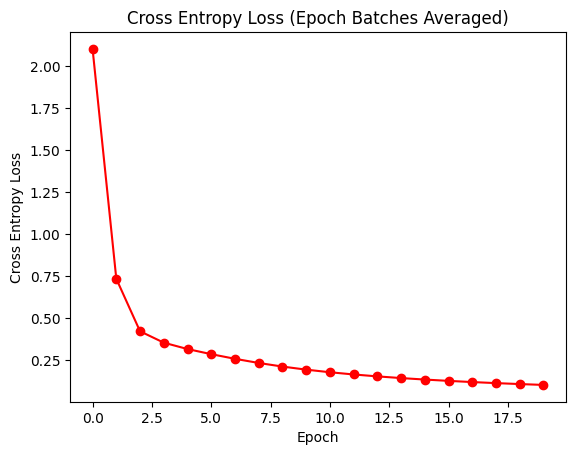

In [146]:
plt.plot(df_losses, 'o-', c='red')
plt.title('Cross Entropy Loss (Epoch Batches Averaged)')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')


torch.Size([28, 28])

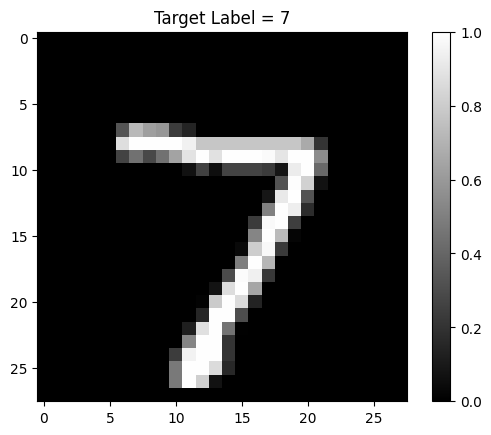

In [70]:
test_set.show_image(0)
test_image = test_set[0][0]
test_image.view(-1, 28**2).shape

In [71]:
prediction = network(test_image.view(-1, 28**2))
torch.argmax(prediction,1)

tensor([7])

In [148]:
xs, ys = test_set[:2000]
yhats = network(xs).argmax(axis=1)

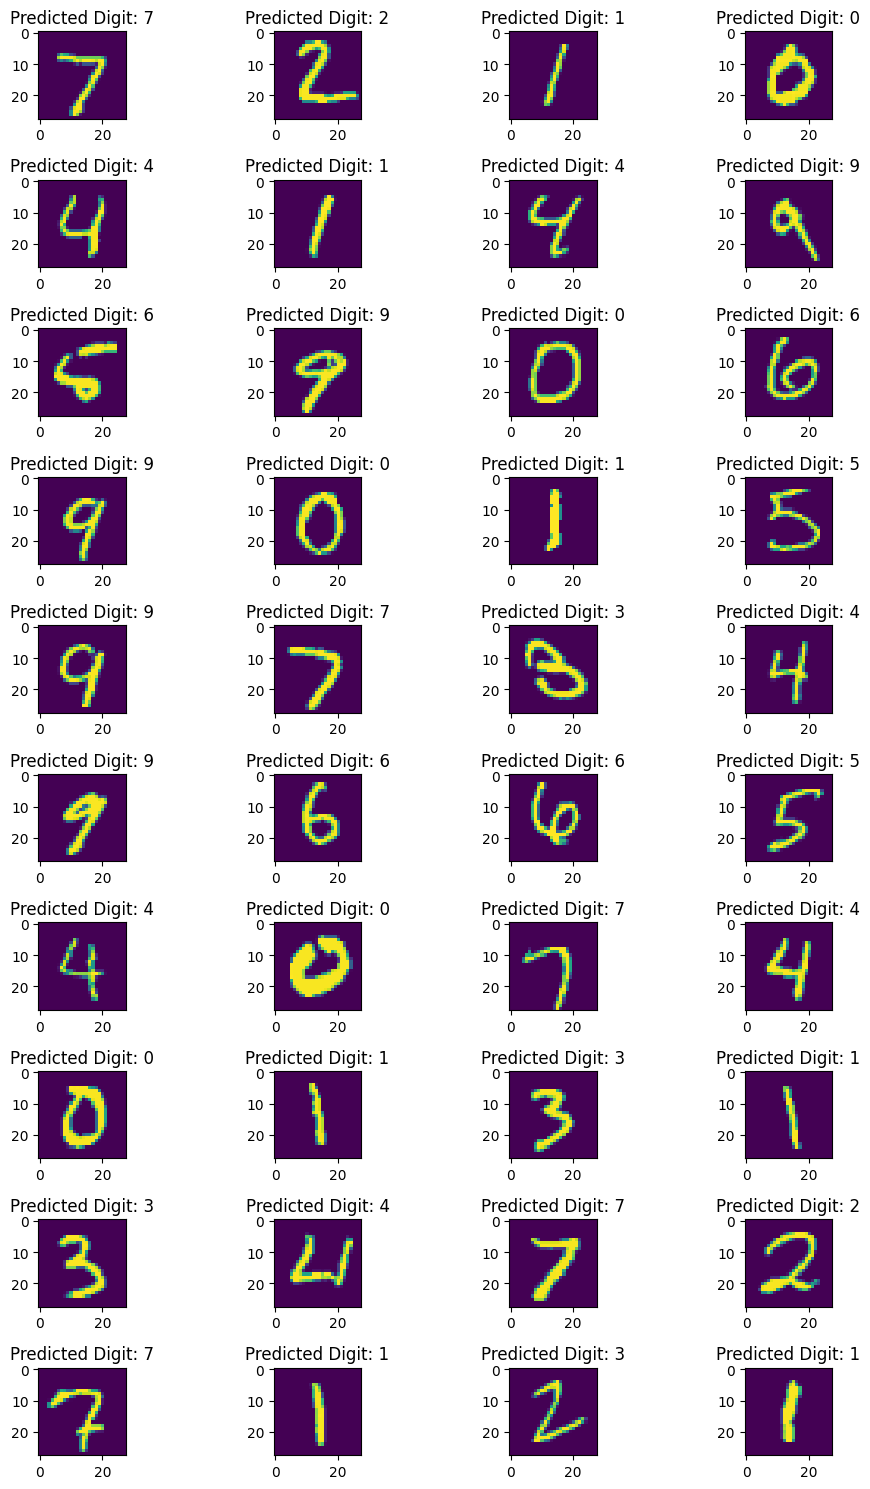

In [149]:
fig, ax = plt.subplots(10,4,figsize=(10,15))
for i in range(40):
    plt.subplot(10,4,i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {yhats[i]}')
fig.tight_layout()
plt.show()